In [1]:
import tensorflow as tf 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense , Flatten ,Dropout
from tensorflow.keras.models import Sequential ,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array , load_img
import matplotlib.pyplot as plt 
import numpy as np 
import cv2
import os 
import pandas as pd 
import pathlib

In [2]:
data_dir = pathlib.Path('./DataSet/Diverse_hand_gesture_dataset/train')

In [3]:
list_d = tf.data.Dataset.list_files(str(data_dir/'*.png') , shuffle=False)

In [4]:
image_count = tf.data.experimental.cardinality(list_d).numpy()
image_count

6400

In [5]:
for name in list_d.take(10):
    print(name.numpy())

b'DataSet\\Diverse_hand_gesture_dataset\\train\\1.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\10.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\100.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1000.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1001.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1002.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1003.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1004.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1005.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1006.png'


In [6]:
lbls = []
bboxes = []

In [7]:
all_files = os.listdir('./DataSet/Diverse_hand_gesture_dataset/train')
txt_files = [f for f in all_files if f.endswith('.txt')]

In [8]:
len(all_files)

12800

In [9]:
txt_files.sort()
txt_files[1]

'10.txt'

In [10]:
for i in txt_files :
    path = './DataSet/Diverse_hand_gesture_dataset/train/{}'.format(i)
    l , startX, startY, Width ,Height = pd.read_csv(path,sep=' ')
    bboxes.append((float(startX[:8]) , float(startY[:8]) , float(Width[:8]) , float(Height[:8])))
    lbls.append(int(l))

In [11]:
lbls_data = tf.data.Dataset.from_tensor_slices(lbls)
bboxes_data = tf.data.Dataset.from_tensor_slices(bboxes)
l2 = tf.data.Dataset.zip((lbls_data,bboxes_data))
dataset = tf.data.Dataset.zip((list_d,l2))

In [12]:
for i in dataset.take(2):
    p,l = i
    print(p , l)

tf.Tensor(b'DataSet\\Diverse_hand_gesture_dataset\\train\\1.png', shape=(), dtype=string) (<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.511161, 0.5625  , 0.245536, 0.3125  ], dtype=float32)>)
tf.Tensor(b'DataSet\\Diverse_hand_gesture_dataset\\train\\10.png', shape=(), dtype=string) (<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.386161, 0.537946, 0.28125 , 0.290179], dtype=float32)>)


In [13]:
dataset = dataset.shuffle(image_count , reshuffle_each_iteration=False)

In [14]:
val_size = int (image_count * 0.1)
train_data = dataset.skip(val_size)
validation_data = dataset.take(val_size)

In [15]:
def decode_img (img) :
    img = tf.io.decode_png(img,channels=3)
    return tf.image.resize(img,[224,224])

In [16]:
def process_path(file_path ,labels):
    img = tf.io.read_file(file_path)
    img = decode_img(img) / 255.0
    l1,l2 = labels
    return img , (l1,l2)

In [17]:
train_data = train_data.map(process_path,num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.map(process_path,num_parallel_calls=tf.data.AUTOTUNE)


train_data = train_data.batch(64)
validation_data = validation_data.batch(64)


train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE)

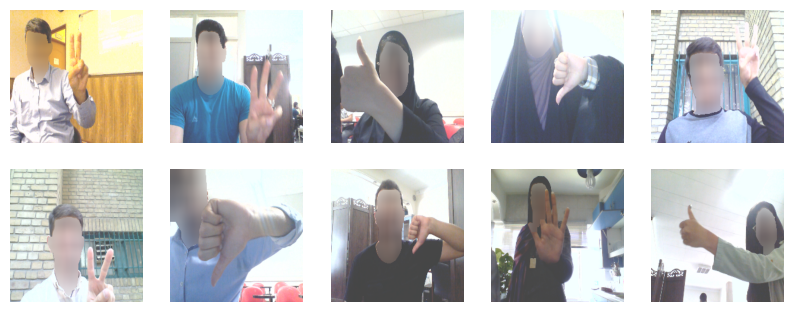

In [18]:
image_batch , label_batch = next(iter(train_data))

plt.figure(figsize=(10,10))
for i in range(10) :
    ax = plt.subplot(5,5,i+1)
    plt.imshow((image_batch[i].numpy()*255).astype('uint8'))
    plt.axis("Off")

In [19]:
# denseNet121 = DenseNet121(weights='./models/densenet121_weights_tf_dim_ordering_tf_kernels.h5' , input_shape=(224,224,3))
vgg = VGG16(weights='./models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False , input_shape=(224,224,3))  

In [20]:
flatten = vgg.output
flatten = Flatten()(flatten)


bboxHead = Dense(128, activation='relu')(flatten)
bboxHead = Dense(64, activation='relu')(bboxHead)
bboxHead = Dense(32, activation='relu')(bboxHead)
bboxHead = Dense(4, activation='sigmoid' , name = "bounding_box")(bboxHead)



softmaxHead = Dense(512,activation = 'relu')(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512,activation = 'relu')(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(8,activation = 'softmax',name = "class_label")(softmaxHead)



model = Model(inputs=vgg.input , outputs = (softmaxHead , bboxHead))



In [21]:
vgg.trainable = False

In [22]:
losses = {
    "bounding_box" : "mean_squared_error",
    "class_label" : "sparse_categorical_crossentropy"
    
}

lossWeights = {
    "bounding_box" : 1.0 ,
    "class_label" : 1.0
    
}

In [23]:
opt = Adam(learning_rate=1e-4)
model.compile(loss=losses,optimizer=opt ,metrics=["accuracy"],loss_weights=lossWeights)

In [24]:
from keras.callbacks import ReduceLROnPlateau

reducelr = ReduceLROnPlateau('bounding_box_loss' , 0.1 ,2,min_lr=1e-6)

In [25]:
history = model.fit(
    train_data,
    validation_data= validation_data,
    epochs = 10,
    callbacks = [reducelr]
)

Epoch 1/10


90/90 [==============================] - 505s 6s/step - loss: 1.8213 - class_label_loss: 1.8109 - bounding_box_loss: 0.0105 - class_label_accuracy: 0.3212 - bounding_box_accuracy: 0.6819 - val_loss: 1.2086 - val_class_label_loss: 1.2036 - val_bounding_box_loss: 0.0050 - val_class_label_accuracy: 0.6687 - val_bounding_box_accuracy: 0.8359 - lr: 1.0000e-04
Epoch 2/10
90/90 [==============================] - 2206s 25s/step - loss: 1.1310 - class_label_loss: 1.1274 - bounding_box_loss: 0.0036 - class_label_accuracy: 0.5858 - bounding_box_accuracy: 0.8457 - val_loss: 0.7520 - val_class_label_loss: 0.7488 - val_bounding_box_loss: 0.0032 - val_class_label_accuracy: 0.7984 - val_bounding_box_accuracy: 0.8734 - lr: 1.0000e-04
Epoch 3/10
90/90 [==============================] - 502s 6s/step - loss: 0.7585 - class_label_loss: 0.7562 - bounding_box_loss: 0.0023 - class_label_accuracy: 0.7443 - bounding_box_accuracy: 0.8753 - val_loss: 0.5012 - val_class_label_loss: 0.4987 - val_boundi

In [26]:
model.save_weights("weght.h5")

In [27]:
decode_predictions = { 0:'Zero' ,  1:'Dislike' ,  2:'Five' ,  3:'Exactly' ,  4:'Two' ,  5:'Three' ,  6:'Left' ,  7:'Like' }

In [28]:
def draw_bbox( img , box , lbl ):
    image = np.copy(img)
    (h,w) = image.shape[:2]
    
    (X , Y , dX , dY) = box[0]
    
    
    X = X*w
    Y = Y*h
    
    dX = dX * w
    dY = dY * h
    
    startX =int( X - dX/2 )
    startY =int( Y - dY/2 )
    
    endX = int ( X + dX/2 )
    endY = int ( Y + dY/2 )
    
    y = startY - 10 if startY - 10 > 10 else startY + 10 
    
    cv2.putText(image , lbl , (startX , y) ,cv2.FONT_HERSHEY_SIMPLEX ,0.65 ,(0,0,0) ,2)
    cv2.rectangle(image, (startX , startY) , (endX , endY) ,(0,0,0) ,2)
    
    return image
     

In [43]:
sample_num = int(input("Enter a Number for prediction :"))
test_path = './DataSet/Diverse_hand_gesture_dataset/test/dislike/{}.png'.format(sample_num)
print("Path is : ", test_path)

Path is :  ./DataSet/Diverse_hand_gesture_dataset/test/dislike/12064.png


1/1 [==============================] - 0s 134ms/step


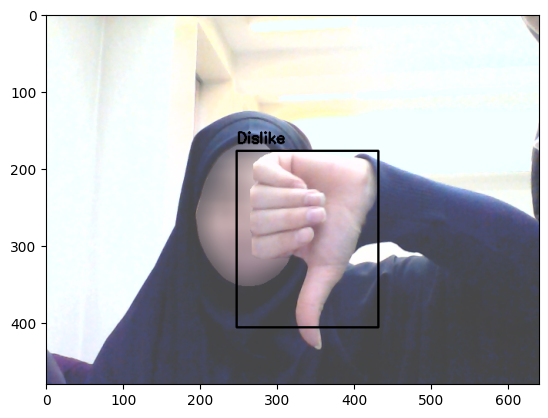

In [44]:
image = load_img(test_path ,target_size=(224,224))
image_show = plt.imread(test_path)
image = img_to_array(image) / 255.0
image = np.expand_dims(image,axis=0)
lbl,box = model.predict(image)
pred_classes = decode_predictions[np.argmax(lbl)]
img = draw_bbox(image_show , box ,pred_classes)
plt.imshow(img)